## Linear Modeling by using House Data

In [6]:
# import 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [7]:
# 분석에 필요한 csv 파일을 호출합니다. 
train = pd.read_csv("../House Prices/train.csv")
test = pd.read_csv("../House Prices/test.csv")

In [8]:
# 파일의 대략적인 형태를 살펴봅니다.
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [9]:
print (train.info())
print ('--------------------------')
print (test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [12]:
# train 데이터와 test 데이터를 한번에 처리하기위하여 .concat()함수를 사용하여 합쳐줍니다.
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

## 데이터 전처리
여기서 사용할 데이터 전처리 방법은 다음과 같습니다.
- 데이터 분포가 한쪽으로 치우친 형태의 데이터는 log를 취하여 정규분포의 형태로 바꿔줍니다.
- Categorical features는 Dummy Vaiables로 바꿔줍니다.
- missing values는 각 column의 평균값으로 대체합니다.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11215ef60>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11303b7f0>]], dtype=object)

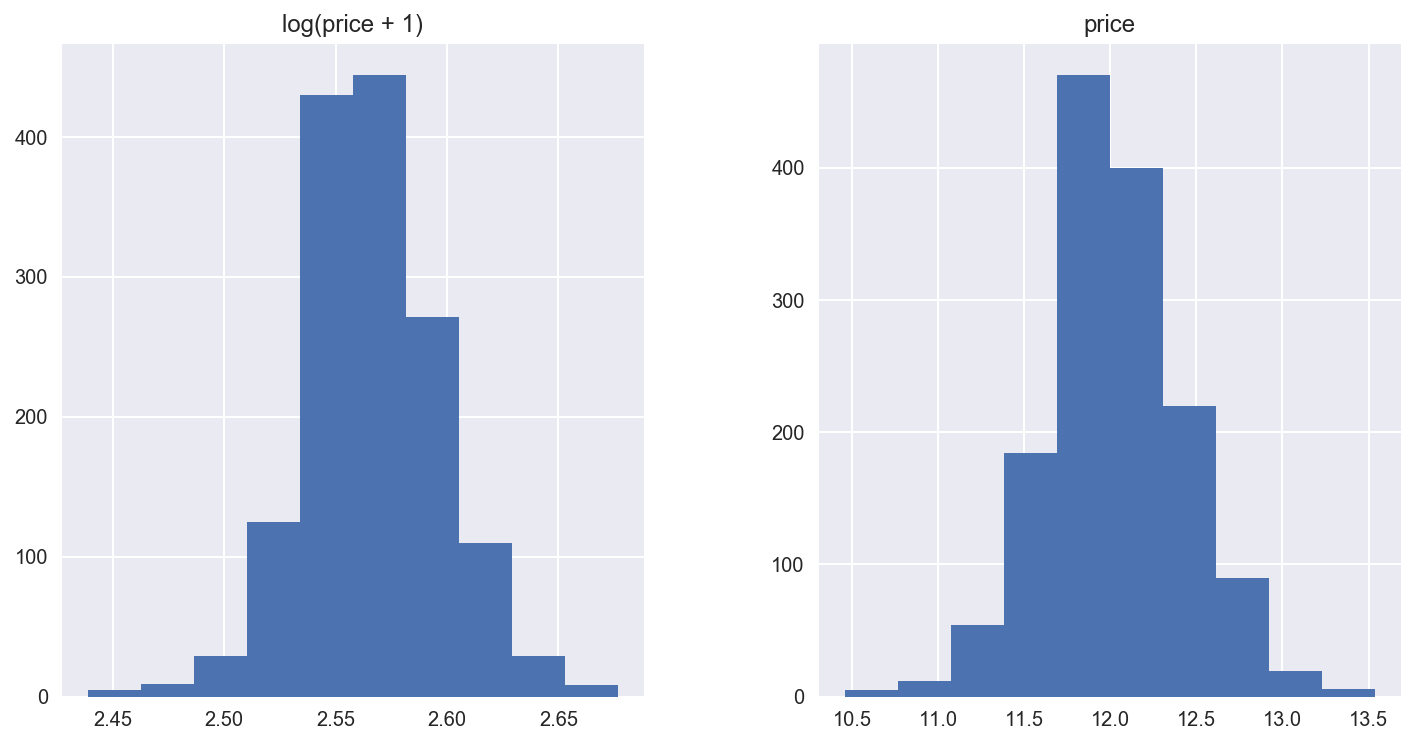

In [13]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train['SalePrice'])})
prices.hist()

In [14]:
# Target Value도 Log값을 취해준다.
train["SalePrice"] = np.log1p(train["SalePrice"])

# 숫자로된 features에 대하여 Log값을 취해준다.
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])


In [15]:
all_data = pd.get_dummies(all_data)

In [16]:
# nan 값들을 각 column의 평균값으로 바꿔줍니다.
all_data = all_data.fillna(all_data.mean())

In [17]:
# sklearn의 모델에 적용하기 위한 형태로 바꿔줍니다.
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

## Models
이제 sklearn에 있는 regularized linear regression models을 사용할 것입니다. 여기서는 L1(Lasso), L2(Ridge) regularization 둘다 사용합니다. 
또한 모델의 성능을 평가하고 최적의 parameter를 골라내기 위하여 cross-validation rmse error를 리턴하는 함수를 정의합니다.

In [18]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return rmse

In [19]:
model_ridge = Ridge()

Ridge model의 tuning parameter는 alpha값으로 이는 우리 모델이 얼마나 유연한지를 측정할수있다. regularization의 값이 클수록 모델이 overfitting의 정도는 줄여주지만 모델 data의 모든 signal을 잡아낼 가능성은 줄어든다. 때문에 적절한 alpha값 설정이 중요하다고 볼수있다.

In [20]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean()
            for alpha in alphas]

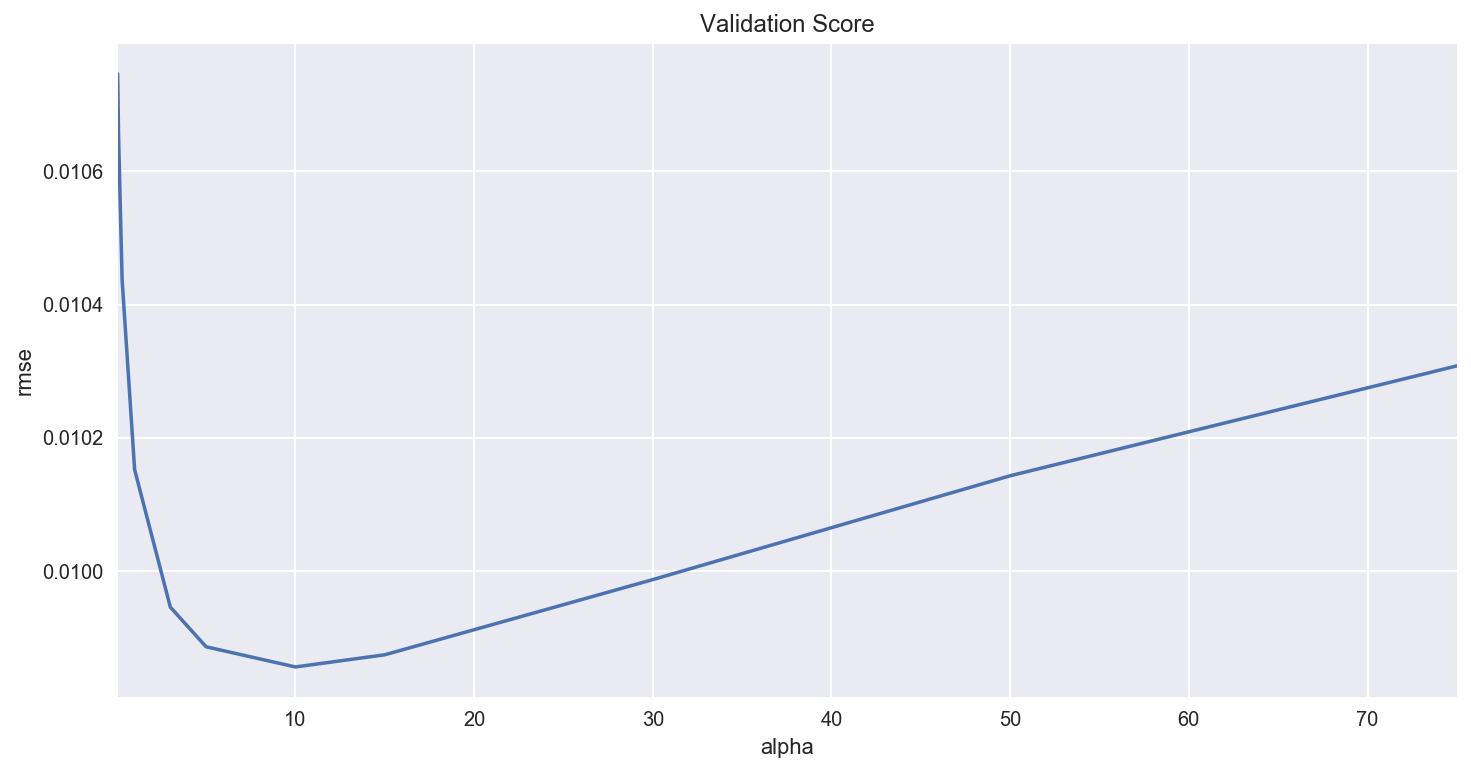

In [21]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation Score")
plt.xlabel("alpha")
plt.ylabel("rmse")

parameter alpha의 rmse값 그래프는 U자형이다. alpha값이 증가할수록 rmse값이 지속적으로 감소하다가 어느 순간이 지나면 다시 상승하는 모습이다.
이 그래프에서 alpha 값이 약 10 정도일때 rmse 값이 최저임을 알수있다.

In [22]:
cv_ridge.min()

0.0098561873033253099

Ridge regression rmse의 최소값으로 0.127 얻었다.

이번에는 Lasso model로 진행해보자. 

In [23]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

In [24]:
rmse_cv(model_lasso).mean()

0.011227594909962854

Lasso 모델의 rmse 최소값은 0.123으로 Ridge 모델보다 더 좋은 결과를 얻었다. 때문에 여기에서는 Lasso 모델을 사용하기로 하자. 
Lasso 모델의 또다른 좋은 점은 feature selection의 기능을 가지고 있다는 것이다. 이는 alpha의 값들을 조정하면서 중요하지 않은 feature의 계수(coefficient)를 0으로 만들어서 의미있는 feature들만 남게 해준다.

Lasso 모델의 feature selection 참고 : http://sosal.kr/868

In [25]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [26]:
print ("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " 
       + str(sum(coef == 0)) + " variables")

Lasso picked 23 variables and eliminated the other 265 variables


dataset의 feature간의 많은 공선성이 존재하기 때문에 Lasso 모델의 feature selection이 항상 옳다고는 볼수없다. 이를 해결하기 위한 한가지 방법은 bootstraped samples에 Lasso 모델을 적용하여 feature selection이 얼마나 안정적으로 되는지를 살펴보는 것이다.

In [27]:
imp_coef = pd.concat([coef.sort_values().head(10),
                      coef.sort_values().tail(10)])

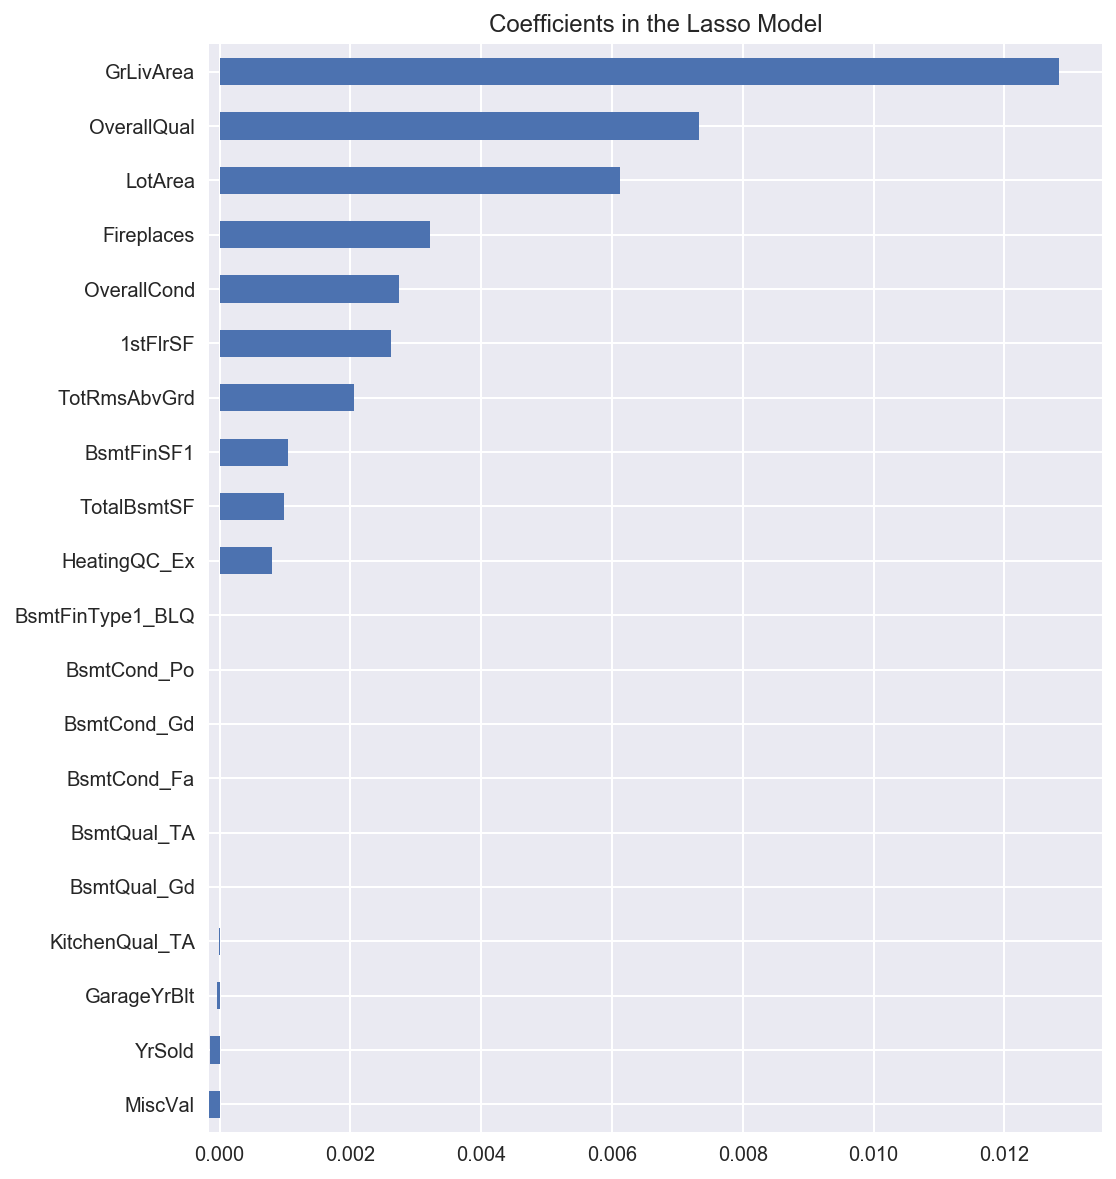

In [28]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = 'barh')
plt.title("Coefficients in the Lasso Model")

가장 주요한 feature는 'GrLivArea' 임을 알수있다. 그리고 몇몇 위치와 품질과 관련된 feature들이 coeffcient가 높은거를 볼수있다.
또한 몇몇의 negative features들을 보면 좀더 살펴볼 필요성이 느껴지는데  아마도 unbalanced categorical variables들로 인해 이러한 결과물이 나오는 것으로 판단된다.


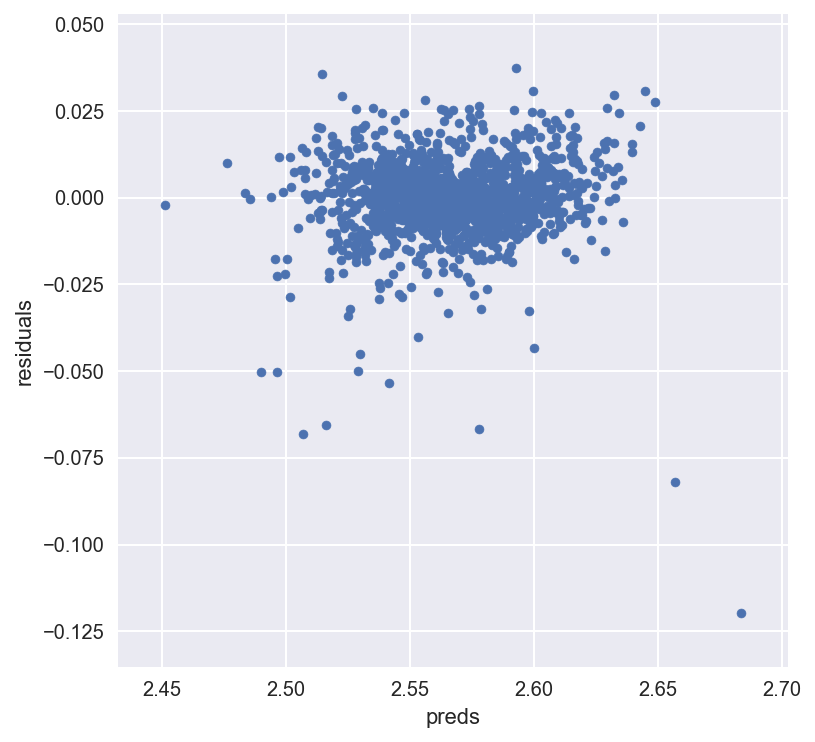

In [29]:
# 실제결과와 모델 예측치간의 residual을 살펴보자
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals", kind = "scatter")

residuals가 0에서 크게 벗어나지 않은 괜찮은 결과물을 얻었다. 이제 이것을 test set에 적용해보자

## Keras 모델 적용
전처리된 데이터를 Keras모델에 적용해보고 결과를 살펴보도록 하자

In [4]:
from keras.layers import Dense
from keras.models import Sequential
from keras.regularizers import l1
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [30]:
X_train = StandardScaler().fit_transform(X_train)

In [31]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y, random_state = 3)

In [32]:
X_tr.shape

(1095, 288)

In [33]:
X_tr

array([[ 1.00573733,  0.68066137, -0.46001991, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [-1.12520184,  0.60296111,  0.03113183, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [-1.12520184, -0.02865265, -0.74027492, ..., -0.11785113,
         0.4676514 , -0.30599503],
       ..., 
       [ 0.16426234, -0.87075036, -0.81954431, ..., -0.11785113,
        -2.13834494, -0.30599503],
       [ 0.92361154, -0.30038284, -0.44275864, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [ 0.83656519,  1.98505948,  0.46455838, ..., -0.11785113,
         0.4676514 , -0.30599503]])

In [35]:
model = Sequential()
model.add(Dense(1, input_dim = X_train.shape[1], W_regularizer=l1(0.001)))
model.compile(loss = 'mse', optimizer = "adam")

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_regularizer=<keras.reg..., input_dim=288)`
  from ipykernel import kernelapp as app


In [37]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 289       
Total params: 289.0
Trainable params: 289
Non-trainable params: 0.0
_________________________________________________________________


In [38]:
hist = model.fit(X_tr, y_tr, validation_data = (X_val, y_val))

Train on 1095 samples, validate on 365 samples
Epoch 1/10
1095/1095 [==============================] - 0s - loss: 8.4556 - val_loss: 8.2036
Epoch 2/10
1095/1095 [==============================] - 0s - loss: 7.6566 - val_loss: 8.2960
Epoch 3/10
1095/1095 [==============================] - 0s - loss: 7.0865 - val_loss: 8.5357
Epoch 4/10
1095/1095 [==============================] - 0s - loss: 6.6334 - val_loss: 8.9387
Epoch 5/10
1095/1095 [==============================] - 0s - loss: 6.2506 - val_loss: 9.4317
Epoch 6/10
1095/1095 [==============================] - 0s - loss: 5.9089 - val_loss: 10.0736
Epoch 7/10
1095/1095 [==============================] - 0s - loss: 5.6146 - val_loss: 10.7931
Epoch 8/10
1095/1095 [==============================] - 0s - loss: 5.3363 - val_loss: 11.5862
Epoch 9/10
1095/1095 [==============================] - 0s - loss: 5.0855 - val_loss: 12.4251
Epoch 10/10
1095/1095 [==============================] - 0s - loss: 4.8569 - val_loss: 13.3871


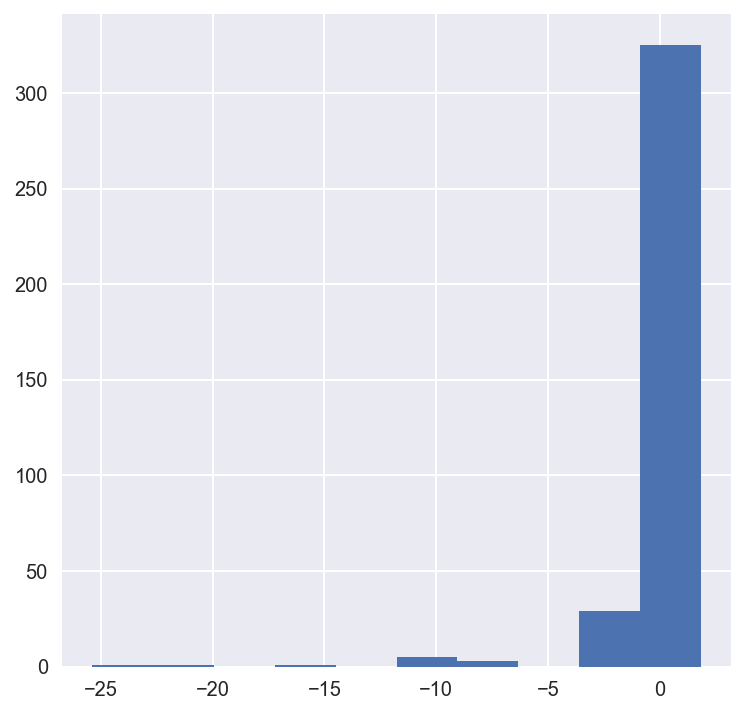

In [40]:
pd.Series(model.predict(X_val)[:,0]).hist()